# High-NA vectorial PSF generation

Detailed models are required to generate high-NA point-spread-functions. Due to the large angles, it is crucial to take into account the vectorial nature of the electric field. This approach allows for accurate modeling of polarization and the inclusion of various correction factors.

In [1]:
from typing import Optional, Tuple

import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
from jax import random

from chromatix.elements import GaussianSource
from chromatix.elements.lenses import HighNALens

key = random.PRNGKey(42)


%load_ext autoreload
%autoreload 2

In [2]:
class HighNAPSF(nn.Module):
    camera_shape: Tuple[int, int] = (256, 256)
    pupil_shape: Tuple[int, int] = (256, 256)
    camera_pixel_pitch: float = 0.005
    f: float = 100
    NA: float = 0.9
    n: float = 1.5
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    pad: int = 0
    taper_width: Optional[float] = 0

    @nn.compact
    def __call__(self):
        field_pup = GaussianSource(
            self.pupil_shape,
            self.wavelength,
            self.wavelength_ratio,
            self.f,
            self.n,
            self.NA,
            power=1,
            amplitude=np.array([0.0, 0.0, 1.0]),
            scalar=False,
            envelope_waist=1,
        )(z=0)

        field = HighNALens(
            self.NA, self.camera_shape, self.camera_pixel_pitch, self.wavelength
        )(field_pup)
        return field, field_pup

260588830.0


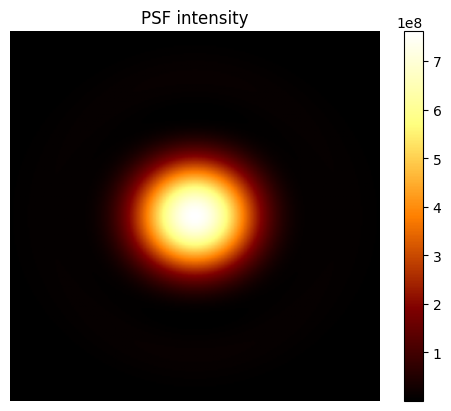

In [3]:
# Initialize model
model = HighNAPSF()
variables = model.init(key)
state = variables["state"]
del variables

output_field, field_pup = model.apply({"state": state})
psf_truth = (np.abs(output_field.u) ** 2).sum(axis=-1)

print(psf_truth.squeeze()[100, 100])

plt.figure()
plt.imshow(psf_truth.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("PSF intensity")
plt.axis("off")
plt.show()

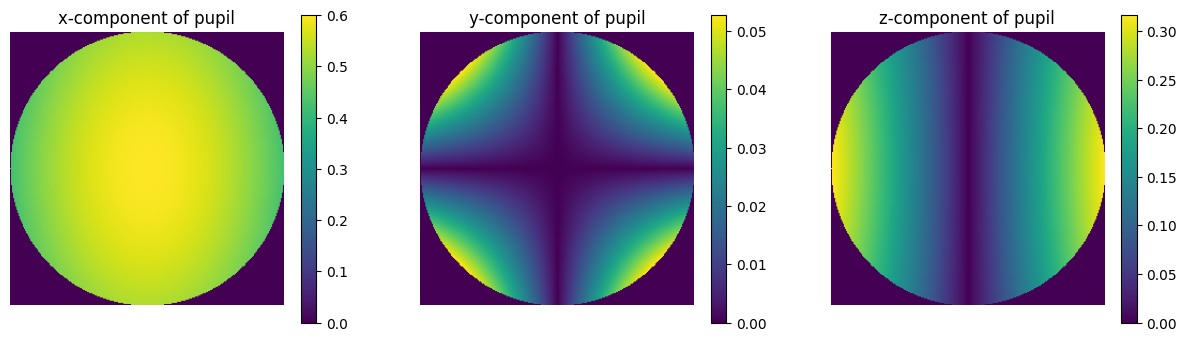

In [4]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 2])
plt.colorbar()
plt.axis("off")
plt.title("x-component of pupil")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 1])
plt.colorbar()
plt.axis("off")
plt.title("y-component of pupil")
plt.subplot(1, 3, 3)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 0])
plt.colorbar()
plt.axis("off")
plt.title("z-component of pupil")
plt.show()